# Functional network construction and cell ranking for in-vitro neuronal populations

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tifffile as tiff
from skimage.feature import blob_dog

### Manual input parameters

In [2]:
expected_neuron_radius_pix = 5
dff_baseline_size = 300
dff_baseline_percent = 75
min_pk_height = 0.2

### Load image stack 


In [90]:
path = '../data/DFFtest.tif'
img = tiff.imread(path) # array of images: use [index] to access a specific slide
img_array = np.array(img) # np array of coordinates/values
# 1st dimension: image, 2nd dimension: row of image, 3rd dimension: col of image
img_array = img_array / 255
# print(img_array[0])

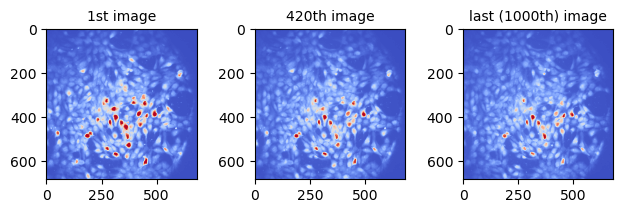

In [98]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.tight_layout()
ax1.set_title("1st image", fontsize=10)
ax1.imshow(img[0], cmap="coolwarm") 
ax2.set_title("420th image", fontsize=10)
ax2.imshow(img[419], cmap="coolwarm") 
ax3.set_title("last (1000th) image", fontsize=10)
ax3.imshow(img[999], cmap="coolwarm") 

In [9]:
mean_img = (np.mean(img_array, axis = 0))


Note: it is too computationally expensive to calculate the entire 682 x 682 standard deviation matrix at once (i.e. kernel crashes), so I calculated two sub-arrays and concatenated them in std_img for the full matrix

In [91]:
test1 = img_array[:, :, :341]
std1 = (np.std(test1, axis = 0))

In [95]:
test2 = img_array[:, :, 341:]
std2 = (np.std(test2, axis = 0))

In [96]:
std_img = np.concatenate((std1, std2), axis=1)

### Measure variance of image

In [23]:
cv_img = std_img / mean_img # coefficient of variation or relative standard deviation
v2_mean_img = (std_img * std_img) / mean_img # variance to mean ratio
recip_img = mean_img / std_img # reciprocal ratio (SNR)
recip_sqimg = (mean_img / std_img) ** 2 # ^^ squared
eff_img = cv_img ** 2 # efficiency

(682, 682)


/var/folders/_c/3ryrb96d5p152b08284fyjvm0000gn/T/ipykernel_61435/3669960295.py:3: RuntimeWarning: divide by zero encountered in true_divide
  recip_img = mean_img / std_img # reciprocal ratio (SNR)
/var/folders/_c/3ryrb96d5p152b08284fyjvm0000gn/T/ipykernel_61435/3669960295.py:4: RuntimeWarning: divide by zero encountered in true_divide
  recip_sqimg = (mean_img / std_img) ** 2 # ^^ squared


Plots

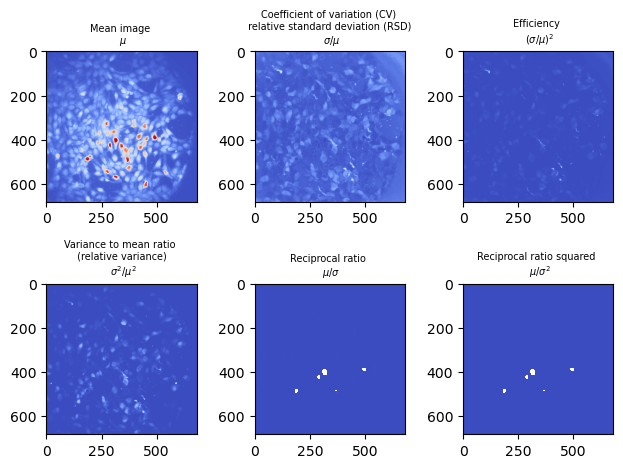

In [89]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3)
fig.tight_layout()

ax1.set_title("Mean image \n $\mu$", fontsize=7)
ax1.imshow(mean_img, cmap='coolwarm')

ax2.set_title("Coefficient of variation (CV) \n relative standard deviation (RSD) \n $\sigma / \mu$", fontsize=7)
ax2.imshow(cv_img, cmap='coolwarm')

ax3.set_title("Efficiency \n $(\sigma / \mu)^2$", fontsize=7)
ax3.imshow(eff_img, cmap='coolwarm')

ax4.set_title("Variance to mean ratio \n (relative variance) \n $\sigma^2 / \mu^2$", fontsize=7)
ax4.imshow(v2_mean_img, cmap='coolwarm')

ax5.set_title("Reciprocal ratio \n $\mu / \sigma$", fontsize=7)
ax5.imshow(recip_img, cmap='coolwarm')

ax6.set_title("Reciprocal ratio squared \n $\mu / \sigma^2$", fontsize=7)
ax6.imshow(recip_sqimg, cmap='coolwarm')

### Identify cell centers

Manual

In [ ]:
# blobs_dog = '../data/insert_path_here'

Load

Automatic (difference of gaussian)

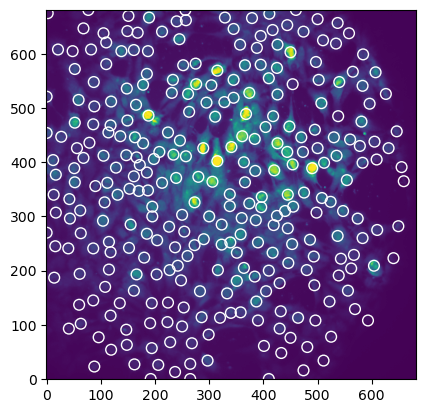

In [115]:
blobs_dog = blob_dog(mean_img, min_sigma=7, max_sigma=10, threshold=0.00666)
blobs_dog[:, 2] = blobs_dog[:, 2] * np.sqrt(2)

ax = plt.gca()
ax.imshow(mean_img,origin='lower')
cnt = 0
while cnt < len(blobs_dog):
    c = plt.Circle((blobs_dog[cnt][1], blobs_dog[cnt][0]), blobs_dog[cnt][2], color='white', linewidth=1, fill=False)
    ax.add_patch(c)
    cnt = cnt + 1
plt.show()


### Extract fluorescence over time from a circle around selected cell coordinates

FUNCTION: fluoro extraction (assume all ROI are the same)

### dF/F calculation

FUNCTION: sliding window dF/F calculation

### Look for peaks (test)

### Correlation coefficient (test)

### Cross correlation (test)

### Distance matrix

### Plot dF/F and correlation matrix

### Get triangles

### Plot distance v correlation scatters

FUNCTION: binned mean

FUNCTION: scatter kernel density estimate

kernel density estimate

desu density scattercloud

### Histogram of correlation coefficient